# 论文名: A hybrid classical-quantum approach for multi-class classification

## 项目介绍

论文中利用变分量子线路实现了三组数据集(Iris dataset, Bankonte Authentication dataset 和 Wireless Indoor Localization dataset)的分类

![circ](./src/图片.jpeg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"]=120

from mindquantum.core import Circuit, UN, H, X, RZ, RY, RX , BarrierGate
from mindquantum.core import QubitOperator
from mindquantum.core import Hamiltonian

import mindspore as ms
from mindquantum.framework import MQLayer
from mindquantum.simulator import Simulator
from mindspore.nn import SoftmaxCrossEntropyWithLogits
from mindspore.nn import Adam, Accuracy
from mindspore import Model
from mindspore.dataset import NumpySlicesDataset
from mindspore.train.callback import Callback, LossMonitor
from mindquantum.algorithm.library import amplitude_encoder
from mindquantum.simulator import Simulator
from mindspore import ops, Tensor


[WARNING] ME(833115:140616947369280,MainProcess):2023-10-17-19:16:28.759.174 [mindspore/run_check/_check_version.py:102] MindSpore version 2.1.0 and cuda version 11.8.89 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


## 导入 Iris  数据

In [2]:
data_iris = pd.read_csv('./src/iris.data', sep='  ', names=['类'])
datas_iris = data_iris.to_numpy()
print("前5个 Iris 数据")
print(data_iris.head())
print("Iris 数据的维度: ", datas_iris.shape)

前5个 Iris 数据
                             类
0  5.1,3.5,1.4,0.2,Iris-setosa
1  4.9,3.0,1.4,0.2,Iris-setosa
2  4.7,3.2,1.3,0.2,Iris-setosa
3  4.6,3.1,1.5,0.2,Iris-setosa
4  5.0,3.6,1.4,0.2,Iris-setosa
Iris 数据的维度:  (150, 1)


/tmp/ipykernel_833115/2710213037.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_iris = pd.read_csv('./src/iris.data', sep='  ', names=['类'])


### 把输入的数据做归一化, 每个特征数据的在 0 到 $\pi/2$ 之间
$
X_i = \frac{\pi}{2}\times\frac{X_i - X_{min}}{X_{max} - X_{min}}
$

In [6]:
# 对输入的数据的最大值和最小值做归一化处理
def min_max_scaling(x, x_min, x_max):

    x_norm = np.pi*(x - x_min)/(2*x_max - 2*x_min)

    return x_norm

# 找到数据每个特征的最大值和最小值
def max_min(data):

    feature = data.shape[1]
    x_max = np.array([max(data[:,i]) for i in range(feature)])
    x_min = np.array([min(data[:,i]) for i in range(feature)])

    return x_max, x_min

# 对于 amplititude encoding 编码方式做归一化处理
# 例如 [2, 2] 变为  [0.5, 0.5]
def normolize(data):

    denominator = sum(data**2)
    return data**2/denominator

## 利用 Amplititude encoding 模块的到每个数据的输入
def amplitude_data_transform(data):

    data_transfrom = []
    sim = Simulator('mqvector', 3)
    encoder, parameterResolver = amplitude_encoder(data, 3)
    sim.apply_circuit(encoder, parameterResolver)
    for i in parameterResolver.values():
        data_transfrom.append(i)
    return data_transfrom

# 打乱数据集
def shuffle_data(data, data_label, num, remomolize=False):

    data_len = len(data)
    index = np.arange(data_len)
    np.random.shuffle(index)  # 将数组打乱
    training_data = []
    training_label = []
    for i in range(data_len):
        if remomolize==False:
            training_data.append(data[index[i]])
            training_label.append(data_label[index[i]])
        else:
            training_data.append(amplitude_data_transform(normolize(data[index[i]])))
            training_label.append(data_label[index[i]])
    return np.array(training_data)[:num, :], np.array(training_label).astype(int)[:num], np.array(training_data)[num:, :], np.array(training_label).astype(int)[num:]


### 文章中给出的量子编发方式, $U_1 H|0\rangle$, 我认为数据已经做了归一化处理并且范围在 0 到 $\pi/2$ ,可以直接用$R_y(2 x_n)$来编码

$$
\begin{equation}
U_1 H|0\rangle    =
\left[
  \begin{array}{ccc}
    \cos(\frac{\pi}{4} - x_n) & -\sin(\frac{\pi}{4} - x_n) \\
    \cos(\frac{\pi}{4} - x_n) & \sin(\frac{\pi}{4} - x_n)  \\
  \end{array}
\right]
\left[
  \begin{array}{ccc}
    \frac{1}{\sqrt{2}}  \\
    \frac{1}{\sqrt{2}}   \\
  \end{array}
\right]
=\left[
  \begin{array}{ccc}
    \cos(x_n)  \\
    \sin(x_n)   \\
  \end{array}
\right]
\end{equation}
$$

### 下面是对得到 Iris  数据

In [7]:
datas_iris_rescaling = np.zeros((len(datas_iris),4))
datas_iris_label = np.zeros((len(datas_iris)))

for i, value in enumerate(datas_iris):
    value = value[0].split(',')
    for j in range(4):
        datas_iris_rescaling[i,j] = value[j]
    if value[-1] == 'Iris-setosa': datas_iris_label[i] = 0
    elif value[-1] =='Iris-versicolor': datas_iris_label[i] = 1
    elif value[-1] == 'Iris-virginica': datas_iris_label[i] = 2

for j in range(4):
    for i in range(len(datas_iris_rescaling)):
        x = datas_iris_rescaling[i,j]
        x_max, x_min = max_min(datas_iris_rescaling)
        datas_iris_rescaling[i,j] = 2*min_max_scaling(x, x_min[j], x_max[j])

### 把数据打乱, 将训练数据分为训练集和测试集

In [8]:
training_data_iris_qmcc, training_label_iris_qmcc, test_data_iris_qmcc, test_label_iris_qmcc = shuffle_data(datas_iris_rescaling, datas_iris_label, 120, remomolize=False)
training_data_iris_AEM, training_label_iris_AEM, test_data_iris_AEM, test_label_iris_AEM = shuffle_data(datas_iris_rescaling, datas_iris_label, 120, remomolize=True)

print("Iris 训练集的维度: ", training_data_iris_qmcc.shape)
print("Iris 训练集标签的维度: ", training_label_iris_qmcc.shape)
print("Iris 测试集的维度: ", test_data_iris_qmcc.shape)
print("Iris 测试集标签的维度: ", test_label_iris_qmcc.shape)

Iris 训练集的维度:  (120, 4)
Iris 训练集标签的维度:  (120,)
Iris 测试集的维度:  (30, 4)
Iris 测试集标签的维度:  (30,)


### 量子编码器，将经典数据转化为量子数据， 变分量子线路先将 $R_y(\theta)$ 旋转门作用在编码器上，然后用CNOT门将 数据比特和辅助比特纠缠在一起，在辅助比特上作用  $R_z(\theta), R_y(\theta), R_z(\theta)$ 门。将编码器和变分量子线路合并在一起，并在线路的最后的辅助比特上施加泡利 $Z$ 算符

### Iris 数据的量子线路  quantummulti-class classifier (QMCC)

===========================================Circuit Summary===========================================
|Total number of gates  : 102.                                                                      |
|Parameter gates        : 53.                                                                       |
|with 53 parameters are :                                                                           |
|alpha0, alpha1, alpha2, alpha3, beta0, beta1, beta2, beta3, beta4, beta5..                        .|
|Number qubit of circuit: 7                                                                         |
[1 [Z4], 1 [Z5], 1 [Z6]]


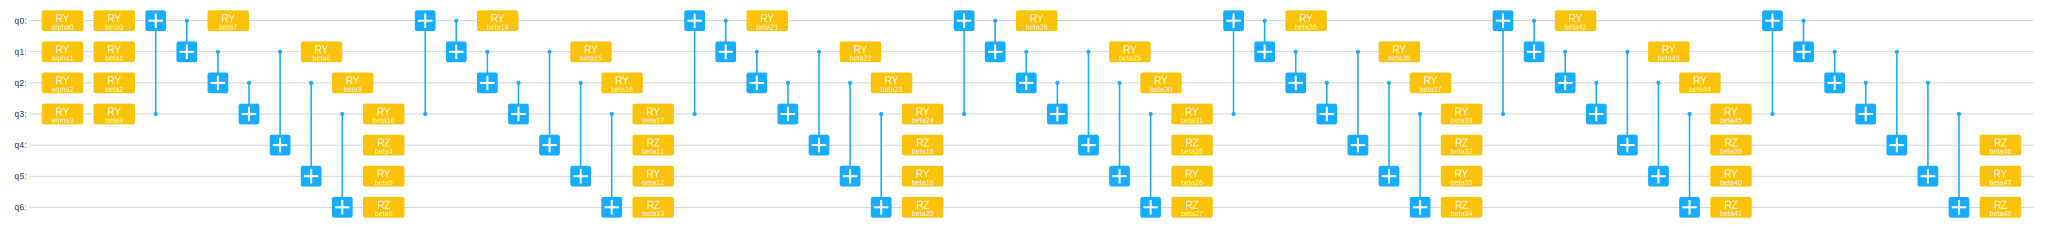

In [21]:
encoder_iris_qmcc = Circuit()
for i in range(4):
    encoder_iris_qmcc += RY(f'alpha{i}').on(i)
encoder_iris_qmcc = encoder_iris_qmcc.no_grad()

ansatz_iris_qmcc = Circuit()
for i in range(7):
    for j in range(4):
        ansatz_iris_qmcc += RY(f'beta{j+7*i}').on(j)

    ansatz_iris_qmcc += X.on(0, 3)                          # X门作用在第j+1位量子比特，受第j位量子比特控制
    for k in range(3):
        ansatz_iris_qmcc += X.on(k+1,k)
    ansatz_iris_qmcc += X.on(4,1)
    ansatz_iris_qmcc += X.on(5,2)
    ansatz_iris_qmcc += X.on(6,3)
    ansatz_iris_qmcc += RZ(f'beta{4+7*i}').on(4)
    ansatz_iris_qmcc += RY(f'beta{5+7*i}').on(5)
    ansatz_iris_qmcc += RZ(f'beta{6+7*i}').on(6)

circuit_iris_qmcc = encoder_iris_qmcc.as_encoder() + ansatz_iris_qmcc.as_ansatz()
circuit_iris_qmcc.summary()
hams_qmcc = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [4, 5, 6]]
print(hams_qmcc)
circuit_iris_qmcc.svg()

### Iris 数据的量子线路  Amplitude embedding model (AEM)

=============================================Circuit Summary=============================================
|Total number of gates  : 52.                                                                           |
|Parameter gates        : 28.                                                                           |
|with 28 parameters are :                                                                               |
|alpha0, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, beta0, beta1, beta2..                        . |
|Number qubit of circuit: 3                                                                             |
[1 [Z0], 1 [Z1], 1 [Z2]]


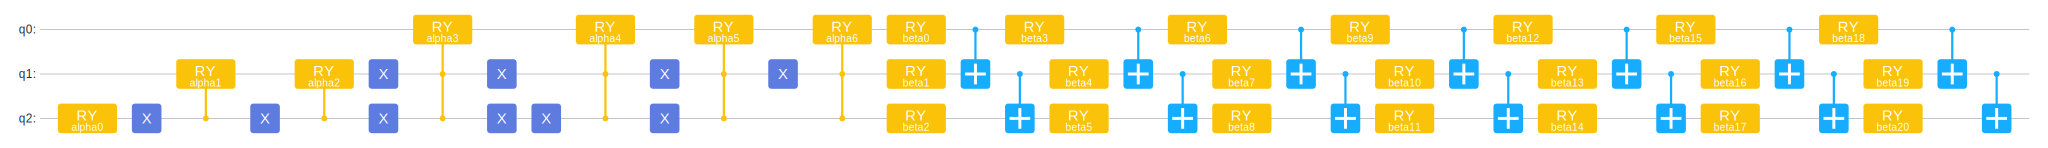

In [22]:
from mindquantum.algorithm.library import amplitude_encoder
from mindquantum.simulator import Simulator
sim = Simulator('mqvector', 3)
encoder_irs_AEM, parameterResolver = amplitude_encoder(training_data_iris_AEM[0], 3)

ansatz_iris_AEM = Circuit()

for i in range(7):
    for j in range(3):
        ansatz_iris_AEM += RY(f'beta{j+3*i}').on(j)
    ansatz_iris_AEM += X.on(1,0)
    ansatz_iris_AEM += X.on(2,1)

circuit_iris_AEM = encoder_irs_AEM.as_encoder() + ansatz_iris_AEM.as_ansatz()
circuit_iris_AEM.summary()
hams_AEM = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [0, 1, 2]]
print(hams_AEM)
circuit_iris_AEM.svg()

## 搭建量子网络

In [23]:
def QuantumNet(circuit, encoder, ansatz, hams):

    ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
    ms.set_seed(1)
    sim = Simulator('mqvector', circuit.n_qubits)
    grad_ops = sim.get_expectation_with_grad(hams,
                                            circuit,
                                            parallel_worker=5)
    QuantumNets = MQLayer(grad_ops)
    return QuantumNets

QuantumNet_Iris_AEM = QuantumNet(circuit_iris_AEM, encoder_irs_AEM, ansatz_iris_AEM, hams_AEM)
QuantumNet_Iris_QMCC = QuantumNet(circuit_iris_qmcc, encoder_iris_qmcc, ansatz_iris_qmcc, hams_qmcc)
print(QuantumNet_Iris_QMCC)
print(QuantumNet_Iris_AEM)

MQLayer<
  (evolution): MQOps<7 qubits mqvector VQA Operator>
  >
MQLayer<
  (evolution): MQOps<3 qubits mqvector VQA Operator>
  >


## 用 Mindspore 进行训练

In [24]:
def data_load(training_data, training_label, test_data, test_label):

    train_loader = NumpySlicesDataset({'features': training_data, 'labels': training_label}, shuffle=False).batch(5)
    test_loader = NumpySlicesDataset({'features': test_data, 'labels': test_label}).batch(5)
    return train_loader, test_loader

def model_structure(QuantumNet):

    loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    opti = Adam(QuantumNet.trainable_params(), learning_rate=0.02)
    model = Model(QuantumNet, loss, opti, metrics={'Acc': Accuracy()})
    return  loss, opti, model

class StepAcc(Callback):
    def __init__(self, model, data_loader):
        self.model = model
        self.data_loader  = data_loader
        self.acc = []

    def step_end(self, run_context):
        self.acc.append(self.model.eval(self.data_loader, dataset_sink_mode=False)['Acc'])

In [25]:
train_loader_qmcc, test_loader_qmcc = data_load(training_data_iris_qmcc, training_label_iris_qmcc, test_data_iris_qmcc, test_label_iris_qmcc)
loss_qmcc, opti_qmcc, model_qmcc  = model_structure(QuantumNet_Iris_QMCC)

monitor = LossMonitor(24)
acc_train_iris_qmcc = StepAcc(model_qmcc, train_loader_qmcc)
acc_test_iris_qmcc = StepAcc(model_qmcc, test_loader_qmcc)

model_qmcc.train(10, train_loader_qmcc, callbacks=[monitor, acc_train_iris_qmcc, acc_test_iris_qmcc ], dataset_sink_mode=False)
print("The training of mode qmcc is finished")


[WARNING] ME(833115:140616947369280,MainProcess):2023-10-17-19:23:02.631.660 [mindspore/train/model.py:1099] For StepAcc callback, {'step_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.
[WARNING] ME(833115:140616947369280,MainProcess):2023-10-17-19:23:02.632.246 [mindspore/train/model.py:1099] For StepAcc callback, {'step_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


epoch: 1 step: 24, loss is 1.0322595834732056
epoch: 2 step: 24, loss is 0.8193796277046204
epoch: 3 step: 24, loss is 0.7783553004264832
epoch: 4 step: 24, loss is 0.7336972951889038
epoch: 5 step: 24, loss is 0.7368140816688538
epoch: 6 step: 24, loss is 0.7696059346199036
epoch: 7 step: 24, loss is 0.7793959379196167
epoch: 8 step: 24, loss is 0.7833284139633179
epoch: 9 step: 24, loss is 0.7845029830932617
epoch: 10 step: 24, loss is 0.7848080992698669
The training of mode qmcc is finished


In [26]:
train_loader_AEM, test_loader_AEM = data_load(training_data_iris_AEM, training_label_iris_AEM, test_data_iris_AEM, test_label_iris_AEM)
loss_AEM, opti_AEM, model_AEM  = model_structure(QuantumNet_Iris_AEM)

acc_train_iris_AEM = StepAcc(model_AEM, train_loader_AEM)
acc_test_iris_AEM = StepAcc(model_AEM, test_loader_AEM)

model_AEM.train(10, train_loader_AEM, callbacks=[monitor, acc_train_iris_AEM, acc_test_iris_AEM ], dataset_sink_mode=False)
print("The training of mode AME is finished")

[WARNING] ME(833115:140616947369280,MainProcess):2023-10-17-19:23:26.525.402 [mindspore/train/model.py:1099] For StepAcc callback, {'step_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.
[WARNING] ME(833115:140616947369280,MainProcess):2023-10-17-19:23:26.527.068 [mindspore/train/model.py:1099] For StepAcc callback, {'step_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


epoch: 1 step: 24, loss is 0.8580257296562195
epoch: 2 step: 24, loss is 0.761610746383667
epoch: 3 step: 24, loss is 0.7266010642051697
epoch: 4 step: 24, loss is 0.6984802484512329
epoch: 5 step: 24, loss is 0.6907322406768799
epoch: 6 step: 24, loss is 0.6868619322776794
epoch: 7 step: 24, loss is 0.6862959265708923
epoch: 8 step: 24, loss is 0.6870850324630737
epoch: 9 step: 24, loss is 0.6873914003372192
epoch: 10 step: 24, loss is 0.6874128580093384
The training of mode AME is finished


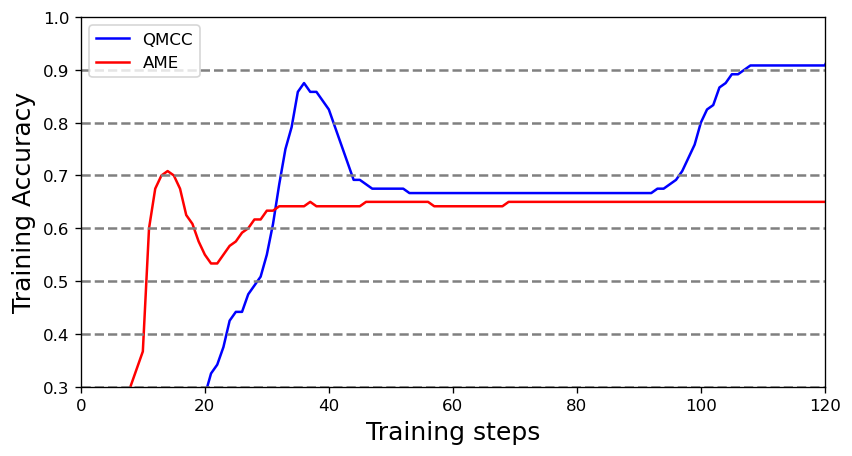

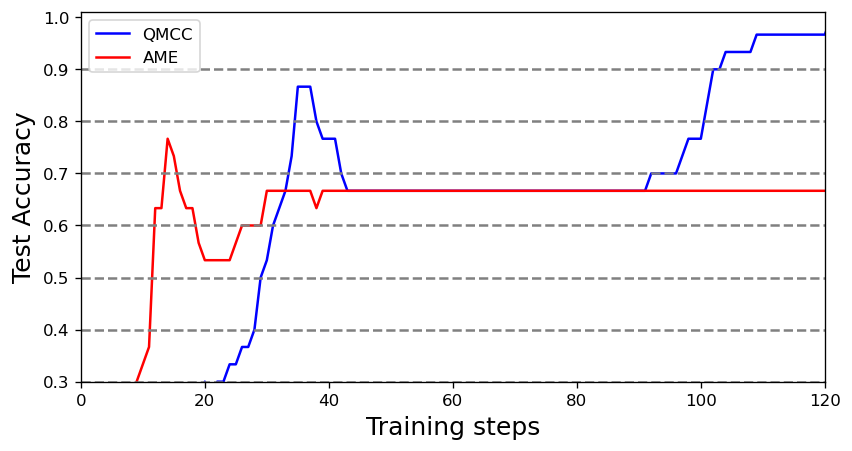

In [27]:
def plot(acc_train_qmcc, acc_test_qmcc, acc_train_amd, acc_test_amd):

    fig = plt.figure(figsize=(8,4))
    plt.plot(acc_train_qmcc.acc, color='b', label='QMCC')
    plt.plot(acc_train_amd.acc, color='r', label='AME')
    for i in np.arange(0.3, 0.9, 0.1):
        plt.axhline(i, color='gray', linestyle='--')
    plt.xlabel('Training steps', fontsize=15)
    plt.ylabel('Training Accuracy', fontsize=15)
    plt.xlim(0, 120)
    plt.ylim(0.3, 1)
    plt.legend()

    fig = plt.figure(figsize=(8,4))
    plt.plot(acc_test_qmcc.acc, color='b', label='QMCC')
    plt.plot(acc_test_amd.acc, color='r', label='AME')
    for i in np.arange(0.3, 0.9, 0.1):
        plt.axhline(i, color='gray', linestyle='--')
    plt.xlabel('Training steps', fontsize=15)
    plt.ylabel('Test Accuracy', fontsize=15)
    plt.xlim(0, 120)
    plt.ylim(0.3, 1.01)
    plt.legend()

    return plt.show()

plot(acc_train_iris_qmcc, acc_test_iris_qmcc, acc_train_iris_AEM, acc_test_iris_AEM)

In [28]:
def accuracy(model_qmcc, model_AEM, test_loader_qmcc, test_load_amd):

    correct_qmcc = model_qmcc.eval(test_loader_qmcc, dataset_sink_mode=False)
    correct_AME = model_AEM.eval(test_load_amd, dataset_sink_mode=False)

    return   correct_qmcc,   correct_AME

correct_qmcc,   correct_AME  = accuracy(model_qmcc, model_AEM, test_loader_qmcc, test_loader_AEM)
print("Test accuracy on Iris dataset of QMCC: %.3f"%(correct_qmcc["Acc"]) )
print("Test accuracy on Iris dataset of AEM: %.3f"%(correct_AME["Acc"]) )

Test accuracy on Iris dataset of QMCC: 0.900
Test accuracy on Iris dataset of AEM: 0.667
